<a href="https://colab.research.google.com/github/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-03/lista03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # Lista 03 - Análise de Dados
        
> Yanna Torres Gonçalves
>
> Mestrado em Ciências da Computação
>
> Matrícula: 587299

In [1]:
!pip install plotnine

In [40]:
import pandas as pd
import numpy as np
import re
import duckdb
import matplotlib.pyplot as plt
from plotnine import *

## a) Ler o dataset fakeTelegram.BR_2022.csv

Utilizamos o mesmo dataset da lista 01, acessando pelo mesmo link.

[https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv](https://github.com/yanna-torres/CKP9011-ciencia-de-dados/blob/lista-01/data/fakeTelegram.BR_2022.csv)

In [3]:
data_url = "https://media.githubusercontent.com/media/yanna-torres/CKP9011-ciencia-de-dados/refs/heads/lista-01/data/fakeTelegram.BR_2022.csv"

df = pd.read_csv(data_url)

In [4]:
df.head(10)

,date_message,id_member_anonymous,id_group_anonymous,media,media_type,media_url,has_media,has_media_url,trava_zap,text_content_anonymous,dataset_info_id,date_system,score_sentiment,score_misinformation,id_message,message_type,messenger,media_name,media_md5
0,2022-10-05 06:25:04,1078cc958f0febe28f4d03207660715f,12283e08a2eb5789201e105b34489ee7,NaN,NaN,NaN,False,False,False,Então é Fato Renato o áudio que eu ouvi no wha...,5,2022-10-05 06:25:28.863641,0.0000,NaN,16385,Texto,telegram,NaN,NaN
1,2022-10-05 06:25:08,NaN,12283e08a2eb5789201e105b34489ee7,NaN,NaN,NaN,False,False,False,"Saiu no YouTube do presidente a 8 horas atrás,...",5,2022-10-05 06:25:28.926311,0.0644,NaN,16386,Texto,telegram,NaN,NaN
2,2022-10-05 06:26:28,92a2d8fd7144074f659d1d29dc3751da,9f2d7394334eb224c061c9740b5748fc,NaN,NaN,NaN,False,False,False,"É isso, nossa parte já foi quase toda feita. N...",5,2022-10-05 06:26:29.361949,-0.3551,0.157242,16366,Texto,telegram,NaN,NaN
3,2022-10-05 06:27:28,d60aa38f62b4977426b70944af4aff72,c8f2de56550ed0bf85249608b7ead93d,94dca4cda503100ebfda7ce2bcc060eb.jpg,image/jpg,NaN,True,False,False,GENTE ACHEI ELES EM UMA SEITA MAÇONÁRICA,5,2022-10-05 06:27:29.935624,0.0000,NaN,19281,Imagem,telegram,NaN,94dca4cda503100ebfda7ce2bcc060eb
4,2022-10-05 06:27:44,cd6979b0b5265f08468fa1689b6300ce,e56ec342fc599ebb4ed89655eb6f03aa,5ad5c8bbe9da93a37fecf3e5aa5b0637.jpg,image/jpg,NaN,True,False,False,NaN,5,2022-10-05 06:28:29.316325,NaN,NaN,507185,Imagem,telegram,NaN,5ad5c8bbe9da93a37fecf3e5aa5b0637
5,2022-10-05 06:28:30,NaN,b52442a5fbc459ae590dca0d215e32f9,NaN,NaN,NaN,False,False,False,Kķkkkkk to rindo até agora....Quem disse q ia ...,5,2022-10-05 06:29:29.046694,0.7003,0.197813,2735,Texto,telegram,NaN,NaN
6,2022-10-05 06:29:09,3b685d44ff197b98d7c9e99b8f6b5281,b52442a5fbc459ae590dca0d215e32f9,NaN,NaN,NaN,False,False,False,*SE ALGUÉM TE PERGUNTAR O QUE FOI QUE BOLSONAR...,5,2022-10-05 06:29:29.33448,0.9716,0.974258,2736,Texto,telegram,NaN,NaN
7,2022-10-05 06:43:51,a7db4ff6a6d35e57be5bcf02f400cec6,857cd5311da1bdc15eb9e6918a47c6c6,4fe93a3772445f64173ef03db1fed83c.jpg,image/jpg,NaN,True,False,False,NaN,5,2022-10-05 06:43:54.51408,NaN,NaN,891535,Imagem,telegram,NaN,4fe93a3772445f64173ef03db1fed83c
8,2022-10-05 07:09:39,d2c33afd13a3165be031b6c244f7140d,d9c080b9db8cd9d0e88e870ce782c01a,30f29cca618753961cb97be95e87e3b4.jpg,image/jpg,NaN,True,False,False,NaN,5,2022-10-05 07:10:16.569761,NaN,NaN,314861,Imagem,telegram,NaN,30f29cca618753961cb97be95e87e3b4
9,2022-10-05 06:29:48,a7e85072244cae15446c9d517dc01a1a,b8a8737812c7fd7d3e0bdbb65ef6306f,NaN,NaN,www.marketingdigitalparavencer.com.br,False,True,False,O Deputado Federal pelo NOVO e que foi candida...,5,2022-10-05 06:29:49.901419,-0.8779,0.035876,7248,Texto,telegram,NaN,NaN


In [5]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


## b) Remova os trava-zaps

Utilizamos a mesma função da lista 01 criada para validar os dados da coluna `trava_zap`. Após atualizar a coluna, criamos um novo dataframe com os dados sem trava-zaps.

In [6]:
def has_trava_zap(message):
  if not isinstance(message, str):
    return False  # Garante que só analisa strings

  # Regra 1: muito longo
  if len(message) > 10000:
    return True

  # Regra 2: caracteres invisíveis
  invisible = ''.join(chr(c) for c in range(0x200B, 0x200F + 1)) + '\uFEFF'
  if sum(message.count(c) for c in invisible) > 100:
    return True

  # Regra 3: emojis repetidos
  emoji_pattern = re.compile("[\U0001F600-\U0001F64F\U0001F300-\U0001F5FF"
                              "\U0001F680-\U0001F6FF\U0001F1E0-\U0001F1FF]+", flags=re.UNICODE)
  emojis = emoji_pattern.findall(message)
  if any(len(e) > 20 for e in emojis):
    return True

  # Regra 4: baixa diversidade
  unique = set(message)
  if len(unique) < 10 and len(message) > 500:
    return True

  return False

In [7]:
df['trava_zap'] = df['text_content_anonymous'].apply(has_trava_zap)

In [8]:
df_clean = df[df['trava_zap'] == False]

In [9]:
df_clean.drop(columns=['trava_zap'], inplace=True)

<ipython-input-9-d18d2c2b7bb2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


## c) Remover as linhas repetidas

In [11]:
df_clean = df_clean.drop_duplicates()

In [12]:
df_clean.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,556305.0,442876.000000,166416.000000,5.563050e+05
mean,5.0,0.017676,0.311496,4.448514e+05
std,0.0,0.463547,0.293146,4.859544e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078334,2.125100e+04
50%,5.0,0.000000,0.196892,1.208690e+05
75%,5.0,0.318200,0.488192,9.724220e+05
max,5.0,0.999200,1.000000,1.516436e+06


## d) Remover textos com menos de 5 palavras

In [13]:
df_clean = df_clean[df_clean['text_content_anonymous'].str.split().str.len() >= 5]

In [14]:
df.describe()

,dataset_info_id,score_sentiment,score_misinformation,id_message
count,557586.0,444157.000000,167238.000000,5.575860e+05
mean,5.0,0.017330,0.312245,4.450617e+05
std,0.0,0.464165,0.293699,4.860211e+05
min,5.0,-1.000000,0.000003,2.000000e+00
25%,5.0,-0.177900,0.078454,2.127500e+04
50%,5.0,0.000000,0.197577,1.210935e+05
75%,5.0,0.318200,0.490351,9.726045e+05
max,5.0,0.999200,1.000000,1.516436e+06


---

Para facilitar a recuperação de dados em alguns casos, vamos utilizar o duckdb também.

In [15]:
conn = duckdb.connect()

conn.execute("CREATE TABLE messages AS SELECT * FROM df_clean")

In [16]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338045 entries, 0 to 557585
Data columns (total 18 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   date_message            338045 non-null  object 
 1   id_member_anonymous     142383 non-null  object 
 2   id_group_anonymous      338045 non-null  object 
 3   media                   126125 non-null  object 
 4   media_type              126125 non-null  object 
 5   media_url               82697 non-null   object 
 6   has_media               338045 non-null  bool   
 7   has_media_url           338045 non-null  bool   
 8   text_content_anonymous  338045 non-null  object 
 9   dataset_info_id         338045 non-null  int64  
 10  date_system             338045 non-null  object 
 11  score_sentiment         337998 non-null  float64
 12  score_misinformation    166402 non-null  float64
 13  id_message              338045 non-null  int64  
 14  message_type            3

In [18]:
numeric_columns = [
    "score_sentiment",
    "score_misinformation"
]

In [19]:
category_columns = [
    "media_type",
    "has_media",
    "message_type",
    "messenger"
]

## e) Para cada atributo numérico apresente

### 1. Medidas de Tendência Central

*   Média Aritmética
*   Mediana
*   Valor máximo e mínimo

In [25]:
score_sentiment_mean = df_clean['score_sentiment'].mean()
score_sentiment_median = df_clean['score_sentiment'].median()
score_sentiment_max = df_clean['score_sentiment'].max()
score_sentiment_min = df_clean['score_sentiment'].min()

score_misinformation_mean = df_clean['score_misinformation'].mean()
score_misinformation_median = df_clean['score_misinformation'].median()
score_misinformation_max = df_clean['score_misinformation'].max()
score_misinformation_min = df_clean['score_misinformation'].min()

In [28]:
numeric_stats_params = {
    'score_sentiment': {
        'mean': df_clean['score_sentiment'].mean(),
        'median': df_clean['score_sentiment'].median(),
        'max': df_clean['score_sentiment'].max(),
        'min': df_clean['score_sentiment'].min()
    },
    'score_misinformation': {
        'mean': df_clean['score_misinformation'].mean(),
        'median': df_clean['score_misinformation'].median(),
        'max': df_clean['score_misinformation'].max(),
        'min': df_clean['score_misinformation'].min()
    }
}

numeric_stats_params_df = pd.DataFrame(numeric_stats_params)
numeric_stats_params_df

,score_sentiment,score_misinformation
mean,0.022497,0.311514
median,0.000000,0.196925
max,0.999200,1.000000
min,-1.000000,0.000003


### 2. Medidas de Variabilidade

*   Desvio em relação à média
*   Variância
*   Desvio Padrão

In [36]:
score_sentiment_mean_deviation = (df_clean['score_sentiment'] - df_clean['score_sentiment'].mean()).abs().mean()
score_sentiment_variance = df_clean['score_sentiment'].var()
score_sentiment_std = df_clean['score_sentiment'].std()

score_misinformation_mean_deviation = (df_clean['score_misinformation'] - df_clean['score_misinformation'].mean()).abs().mean()
score_misinformation_variance = df_clean['score_misinformation'].var()
score_misinformation_std = df_clean['score_misinformation'].std()

In [34]:
numeric_stats_variablity_params = {
    'score_sentiment': {
        'mean_deviation': score_sentiment_mean_deviation,
        'variance': score_sentiment_variance,
        'std': score_sentiment_std
    },
    'score_misinformation': {
        'mean_deviation': score_misinformation_mean_deviation,
        'variance': score_misinformation_variance,
        'std': score_misinformation_std
    }
}

numeric_stats_variablity_params_df = pd.DataFrame(numeric_stats_variablity_params)
numeric_stats_variablity_params_df

,score_sentiment,score_misinformation
mean_deviation,0.425371,0.243704
variance,0.280067,0.085937
std,0.529214,0.293150


### 3. Tabela de Frequência e Histograma

### 4. Boxplot

<Axes: >

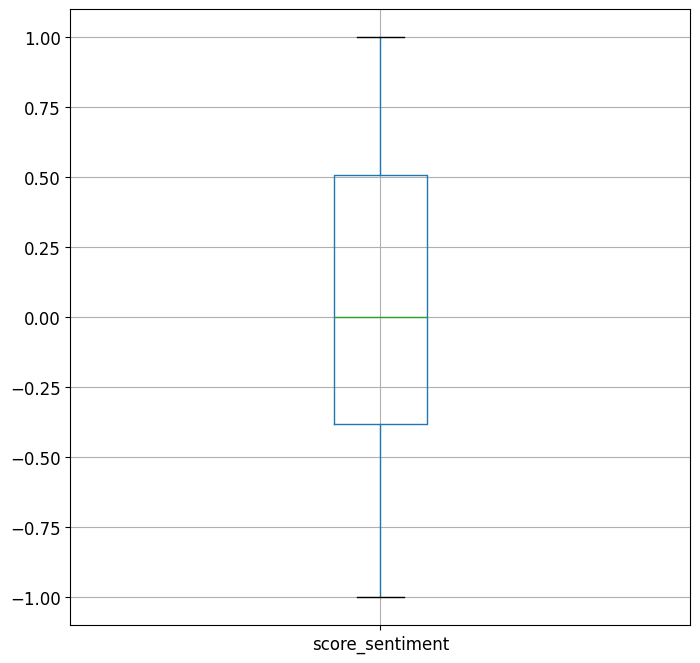

In [37]:
df_clean.boxplot(column=['score_sentiment'], fontsize='large', figsize=(8,8))

<Axes: >

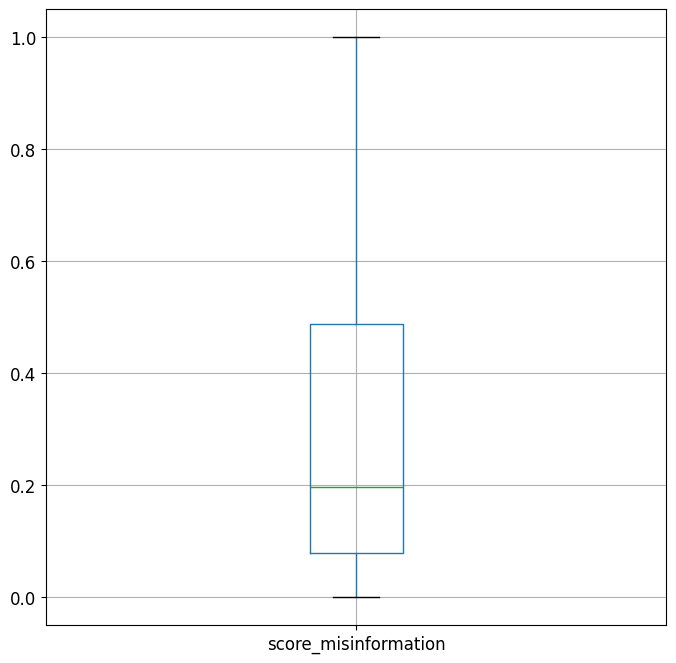

In [38]:
df_clean.boxplot(column=['score_misinformation'], fontsize='large', figsize=(8,8))

### 5. QQ-Plot

### 6. Teste de Normalidade

### 7. Best Fit Distribution (usando diferentes métodos)

## f) Para cada par de atributos númericos apresente

### 1. O Coeficiente de Correlação apropriado

### 2. Um Gráfico de Dispersão

## g) Para cada par de atributos categóricos apresente

### 1. O resultado do método V de Cramer

## h) Crie uma visualização (gráfico) para apresentar

### 1. As quantidades de grupos, usuários e mensagens

### 2. A quantidade de mensagens que ponssuem apenas texto X mídia

### 3. Quantidade de mensagens por tipo de mídia (jpg, mp4 etc)

### 4. Relação entre a quantidade de mensagens e a quantidade de palavras presente nas mensagens

### 5. Quantidade de mensagens por estado

### 6. Quantidade de usuários por estado

### 7. Relação quantidade de usuários por quantidade de mensagens por estado

### 8. Quantidade de mensagens por país

### 9. Quantidade de mensagens Brasil X Países Estrangeiros

Não há informações sobre estado